In [1]:
# default_exp ocr_crnn_training

In [1]:
#export
from fastai import *
from fastai.vision import *
import pandas as pd
import numpy as np
import cv2
from tqdm.notebook import tqdm

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#export
from ocr.core import save_inference, load_inference
from ocr.ocr_dataset_sroie2019 import create_df as create_sroie_df
from ocr.ocr_dataset_sroie2019 import sroie_ocr_config, DATA_PATH, char_freq
PAD = sroie_ocr_config.PAD # PAD - how much is data padded

In [4]:
assert DATA_PATH == os.path.join('../data/ocr/lines')

In [5]:
#export
allowed_chars = {'N', '3', 'V', 'P', '7', '1', '#', '9', '"', 'C', 'Q', 'B', 'E', '>', '@', ',', 'M', '{', ']', 
                 ';', '^', "'", '&', '6', 'Z', '*', '<', '+', 'G', 'X', '!', ':', '-', '[', '|', '$', '5', 'I', 
                 'H', '=', 'Y', '.', 'R', 'S', '/', 'T', '}', 'K', '0', '?', 'U', ')', '_', 'D', 'J', 'L', '4', 
                 'W', '%', '(', '\n', ' ', 'F', '8', '~', '\\', 'A', '2', 'O'}

class crnn_config:
    LINE_HEIGHT = 48
    USE_DEFAULT_CLASSES = True
    label_delim = '`'
    allowed_chars = allowed_chars

### Prep

In [6]:
print(char_freq)

{'`': 1, '·': 1, '{': 3, '}': 3, '\\': 6, '|': 6, ';': 12, '<': 13, '>': 15, '^': 19, '_': 19, '\n': 20, '~': 24, '?': 26, '[': 66, ']': 66, '"': 166, '+': 229, '=': 324, '!': 381, "'": 408, '#': 625, '$': 648, '&': 707, 'Z': 768, '@': 1165, 'Q': 1167, '*': 1473, '%': 1831, 'W': 2910, 'J': 2992, 'V': 3438, '/': 3797, 'F': 3843, ',': 4191, 'X': 4732, ')': 4751, '(': 4766, 'K': 4998, '-': 5566, 'Y': 6216, 'B': 6544, '9': 7544, '7': 8285, '8': 9326, 'P': 9432, '4': 9437, '6': 9660, 'H': 9737, ':': 10516, '5': 10837, '3': 11966, 'G': 12409, 'U': 12589, 'D': 12721, 'C': 14645, '2': 15001, 'M': 15211, 'L': 17481, '.': 19307, 'I': 21104, '1': 22127, 'R': 23724, 'O': 25649, 'N': 26187, 'S': 28138, 'E': 30652, 'T': 32246, 'A': 40094, '0': 42829, ' ': 64128}


In [7]:
chars = list(char_freq.keys())
label_delim = crnn_config.label_delim
label_delim in chars

True

In [8]:
allowed_chars = set(chars) - set(['·', label_delim])
print(allowed_chars)
len(allowed_chars)

{'6', '9', 'Y', '#', ';', 'V', '\n', 'C', '.', 'K', 'J', '/', '(', 'T', ':', 'N', '8', 'I', '|', 'R', ' ', 'F', '[', '*', ']', 'X', '?', 'G', "'", 'H', '{', '1', 'U', '2', '^', 'S', '~', 'Z', '7', '>', '5', 'L', '-', 'A', '<', '4', '3', '+', 'E', '&', 'W', '@', '}', ')', '0', '"', '_', ',', 'O', '$', 'P', 'M', '\\', '=', '!', 'D', 'Q', '%', 'B'}


69

In [9]:
allowed_chars = crnn_config.allowed_chars

In [10]:
split_chars = lambda string, delim: ''.join([char+delim for char in string])[:-1]

def preprocess_string(string):
    string = string.replace('·', '.')
    string = string.replace('`', "'")
    string = split_chars(string, label_delim)
    return string

split_chars('qwerty', label_delim)

'q`w`e`r`t`y'

In [11]:
sroie_df = create_sroie_df()
sroie_df.head()

,image_path,string,valid,dataset
0,X51006327978.0.jpg,Y SOON FATT S/B (81497-P),False,sroie2019
1,X51006327978.1.jpg,"LOT 1504, BATU 8 1/2, JALAN KLANG LAMA,",False,sroie2019
2,X51006327978.2.jpg,"46000 PETALING JAYA, SELANGOR.",False,sroie2019
3,X51006327978.3.jpg,TEL : 016-2014209,False,sroie2019
4,X51006327978.4.jpg,GST REG NO : 000788250624,False,sroie2019


In [12]:
main_df = sroie_df

In [13]:
main_df['string'] = main_df['string'].map(preprocess_string)
main_df.head()

,image_path,string,valid,dataset
0,X51006327978.0.jpg,Y` `S`O`O`N` `F`A`T`T` `S`/`B` `(`8`1`4`9`7`-`P`),False,sroie2019
1,X51006327978.1.jpg,"L`O`T` `1`5`0`4`,` `B`A`T`U` `8` `1`/`2`,` `J`...",False,sroie2019
2,X51006327978.2.jpg,"4`6`0`0`0` `P`E`T`A`L`I`N`G` `J`A`Y`A`,` `S`E`...",False,sroie2019
3,X51006327978.3.jpg,T`E`L` `:` `0`1`6`-`2`0`1`4`2`0`9,False,sroie2019
4,X51006327978.4.jpg,G`S`T` `R`E`G` `N`O` `:` `0`0`0`7`8`8`2`5`0`6`2`4,False,sroie2019


In [14]:
sparse_df = pd.concat([ main_df[ main_df['valid'] == False ].iloc[0:10000:2], main_df[ main_df['valid'] == True ].iloc[:500] ])
sparse_df.head()

,image_path,string,valid,dataset
0,X51006327978.0.jpg,Y` `S`O`O`N` `F`A`T`T` `S`/`B` `(`8`1`4`9`7`-`P`),False,sroie2019
2,X51006327978.2.jpg,"4`6`0`0`0` `P`E`T`A`L`I`N`G` `J`A`Y`A`,` `S`E`...",False,sroie2019
4,X51006327978.4.jpg,G`S`T` `R`E`G` `N`O` `:` `0`0`0`7`8`8`2`5`0`6`2`4,False,sroie2019
6,X51006327978.6.jpg,D`E`S`C,False,sroie2019
8,X51006327978.8.jpg,P`R`I`C`E,False,sroie2019


### Databunch

In [15]:
#export
# label_delim = '`' # '<pad>''

class MultiCategoryProcessor(PreProcessor):
    "`PreProcessor` that create `classes` from `ds.items` and handle the mapping."
    def __init__(self, ds:ItemList):
        self.create_classes(ds.classes)
        self.use_default_classes = crnn_config.USE_DEFAULT_CLASSES
        self.default_classes = crnn_config.allowed_chars
        
    def create_classes(self, classes):
        self.classes = classes
        if classes is not None: self.c2i = {v:k for k,v in enumerate(classes)}

    def process_one(self,item):
        ''' list of chars from `MultiCategoryList.get()` '''
        return [ self.c2i[c] if c in self.c2i else 0 for c in item ]
    
    def process(self, ds):
        if self.classes is None: self.create_classes(self.generate_classes(ds.items))
        ds.classes = self.classes
        ds.c2i = self.c2i
        super().process(ds)

    def generate_classes(self, items):
        ''' items = [ ['h', 'e', 'l', 'l', 'o'], [...], ...] '''
        "Generate classes from `items` by taking the sorted unique values."
        if self.use_default_classes:
            classes = list(self.default_classes)
        else:
            classes = set()
            for c in items: classes = classes.union(set(c))
            classes = list(classes)
        classes.sort()
        return [crnn_config.label_delim] + classes # CHANGED

In [16]:
#export
class MultiCategory(ItemBase):
    "Basic class for multi-classification labels."
    def __init__(self, data, obj, raw): self.data, self.obj, self.raw = data, obj, raw
    def __str__(self):  return crnn_config.label_delim.join([str(o) for o in self.obj])
    def __hash__(self): return hash(str(self))

In [17]:
#export
def one_hot_text(x:Collection[int], c:int):
    "One-hot encode `x` with `c` classes."
    ''' x w/ len of n returns [n,c] shape arr '''
    res = np.zeros((len(x),c), np.float32)
    res[np.arange(len(x)), listify(x)] = 1.
    return res

In [18]:
#export
class MultiCategoryList(ItemList):
    "Basic `ItemList` for multi-classification labels."
    _processor = MultiCategoryProcessor
    def __init__(self, items:Iterator, classes:Collection=None, label_delim:str=None, one_hot:bool=False, **kwargs):
        self.classes = classes
        items = [line.split(crnn_config.label_delim) for line in items] # CHANGED
        super().__init__(items, **kwargs)
        self.processor = [MultiCategoryProcessor(self)]

    def get(self, i):
        o = self.items[i] # list of ints that represent chars
        return MultiCategory(tensor(o), [self.classes[p] for p in o], o) # CHANGED

    def analyze_pred(self, pred, thresh:float=0.5):
        return (pred >= thresh).float()

    def reconstruct(self, data_out):
        if isinstance(data_out, list): # output of data
            t_argmax, _, lengths = data_out
        else: # output from nn
            t_argmax = torch.argmax(data_out, axis=-1) # CHANGED
#         t = data_out[0] if isinstance(data_out, list) else data_out # if train mode it returns tuple
        ''' t [n,c] tensor '''
        o = [int(i) for i in t_argmax] # CHANGED
        return MultiCategory(one_hot_text(o, self.c), [self.classes[p] for p in o], o)
    
    @property
    def c(self): return len(self.classes)

In [19]:
#export
def im2seq_data_collate(batch:ItemsList, pad_idx:int=0)->Tensor:
    if isinstance(batch[0][1], int): return data_collate(batch)
    "Convert `batch` items to tensor data."
    data = to_data(batch) # list of (image, text) pairs
    # image: [3,48,w], text: [n,c], where n's and w's are different
    max_w = max([image.shape[2] for image, text in data])
    max_h = max([image.shape[1] for image, text in data])
    max_n = max([text.shape[0] for image, text in data])
#     _, num_classes = data[0][1].shape
    
    images = torch.zeros(len(batch), 3, max_h, max_w)
#     texts = torch.zeros(len(batch), max_n, num_classes)
    texts = []
    nn_out_seq_len, texts_len = [], []
    for i, (image, text) in enumerate(data):
        c,h,w = image.shape
        images[i, : , : , :w ] = image
        images[i, : , : , w: ] = image[:,:,w-1].unsqueeze(2).expand(c,h,max_w-w)
        nn_out_seq_len.append( image_width2seq_len(w) )
        n = text.size(0)
        texts.append( tensor(text) )
#         texts[i, :n , : ] = tensor(text)
#         texts[i, n: , -1 ] = 1
        texts_len.append(n)
#     texts = torch.cat(texts, axis=0)
    return images, (texts, tensor(nn_out_seq_len).type(torch.int), tensor(texts_len).type(torch.int))

In [20]:
#export
def str2lines(string, n=50):
    return ''.join([s+'\n' if (i+1)%n == 0 else s for i,s in enumerate(string)])

str2lines('asdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasd')

'asdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdas\ndasdasdasdasdasdasdasd'

In [21]:
#export
class MyImageList(ImageList):
    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, 1, imgsize=imgsize, figsize=figsize) # CHANGED rows -> 1
        for x,y,ax in zip(xs, ys, axs.flatten()): x.show(ax=ax, y=y, **kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()
        
    def show_xyzs(self, xs, ys, zs, imgsize:int=20, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
#         if self._square_show_res:
        title = 'Ground truth\nPredictions'
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, 1, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=12) # CHANGED rows -> 1
        for x,y,z,ax in zip(xs,ys,zs,axs.flatten()):
            x.show(ax=ax, title=f'y_true: {str2lines(str(y))}\n\ny_pred: {str2lines(str(z))}', **kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
#         else:
#             title = 'Ground truth/Predictions'
#             axs = subplots(len(xs), 2, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
#             for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
#                 x.show(ax=axs[i,0], y=y, **kwargs)
#                 x.show(ax=axs[i,1], y=z, **kwargs)

In [22]:
#export
def _gaussian_blur(x, size:uniform_int):
    blurred = cv2.blur(image2np(x), (size,size)) # np.arr
#     blurred = cv2.GaussianBlur(image2np(x), (size,size), 0)
    return tensor(blurred).permute(2,0,1)

def gaussian_blur(size, p=1.0):
    return RandTransform(tfm=TfmPixel(_gaussian_blur), kwargs={'size':size}, p=p, resolved={}, do_run=True, is_random=True, use_on_y=False)

In [23]:
#export
resize_one_img = lambda x, size: F.interpolate(x[None], size=size, mode='bilinear', align_corners=True)[0]

def resize_tfm(x, pad:uniform_int, line_height=crnn_config.LINE_HEIGHT):
    ''' size of subtracted padding '''
    c,h,w = x.shape
    x = x[ : , pad:h-pad , pad:w-pad ]
    new_w = int(w * line_height / float(h))
    return resize_one_img(x, size=(line_height, new_w))

def rand_resize(pad, p=1.0):
    return RandTransform(tfm=TfmPixel(resize_tfm), kwargs={'pad':pad}, p=p, resolved={}, do_run=True, is_random=True, use_on_y=False)

In [24]:
#export
train_transforms = [
    rand_resize(pad=(0,PAD), p=1.0),
    rotate(degrees=(-2, 2), p=0.6),
    symmetric_warp(magnitude=(-0.03, 0.03), p=0.1),
    rand_zoom(scale=(0.9,1.03), p=0.5),
    brightness(change=(0.35, 0.65), p=0.4),
    contrast(scale=(0.7,1.3), p=0.4),
    gaussian_blur(size=(1, 7), p=0.2),
#     squish(scale=(0.85,1.15), p=0.3),
    cutout(n_holes=(0,6), length=(1,10)), # black rect
#     tilt(direction=(0,3), magnitude=(-0.2,0.2), p=0.3)
]

valid_transforms = [
    rand_resize(pad=(0,0), p=1.0) # (no padding, but need to resize)
]

In [25]:
#export
def create_data(df, bs=32):
    ''' DataFrame (df) -> Dataloader (dl) '''
    data = (MyImageList.from_df(df, path=DATA_PATH, cols='image_path')
        .split_from_df(col='valid')
        .label_from_df(cols='string', label_cls=MultiCategoryList, label_delim=crnn_config.label_delim)
        .transform((train_transforms, valid_transforms), tfm_y=False)
        .databunch(bs=bs, collate_fn=im2seq_data_collate)
        .normalize(imagenet_stats)
    )
    return data

### Model

In [26]:
#export
def conv_output(w, ss, ps=None, ks=3):
    ''' image width, strides, pools, kernel sizes '''
    for s,p,k in zip(ss,ps,ks):
        s = s[1] if isinstance(s, tuple) else s
        w = w if w%s == 0 else w + 1
        w = (w - k + 2*p)/s + 1 if p is not None else w/s
    return int(w)

In [27]:
conv_output(129, [2, 1, 2, 1, (2,1), (2,1), 1], [None] * 6 + [0], [3, 3, 3, 3, 3, 3, 3])

31

In [28]:
#export
class CRNN(nn.Module):

    def __init__(self, nclass=10, nc=3, rnn_hidden=256, bidirectional=True):
        super(CRNN, self).__init__()
        self.nclass = nclass
        kernels = [3, 3, 3, 3, 3, 3, 3]
        strides = [2, 1, 2, 1, (2,1), (2,1), 1]
        channels = [64, 128, 256, 256, 512, 512, 512]
        padding = [None] * 6 + [0] # None - out size doesnt change
        
        self.kernels, self.strides, self.channels, self.padding = kernels, strides, channels, padding
        
        layers = []
        for i,o,k,s,p in zip([3] + channels[:-1], channels, kernels, strides, padding):
            layers.append( conv_layer(ni=i, nf=o, ks=k, stride=s, padding=p) )
            
        self.cnn = nn.Sequential(*layers)
        
        self.rnn = nn.LSTM(channels[-1], rnn_hidden, bidirectional=bidirectional)
        mult = 1 if not bidirectional else 2
        self.linear = nn.Linear(rnn_hidden * mult, nclass)
        
#     def eval(self): # (quick fix) model.eval() returns bad outputs w/ BatchNorm 
#         return self

    def forward(self, x): # input: [b, 1, h, w]
        # output: ([b,s,c], [b]) (output, seq lengths)
        x = self.cnn(x) # [b,512,1,w/4-2]
        b, c, h, w = x.size()
        assert h == 1, "the height of conv must be 1"
        # [b,512,1,w] -> [s,b,512] (w == s)
        x = x.squeeze(2).permute(2, 0, 1) # [b,c,w] (w == s)
        # [s,b,512] -> [s,b,c]
        x, _ = self.rnn(x)
        x = self.linear(x)
#         nn_output = (x, pad_mask)
        return x.permute(1,0,2)

In [29]:
CRNN()(torch.zeros(2,3,48,128)).shape

torch.Size([2, 30, 10])

In [30]:
crnn = CRNN()

In [31]:
#export
image_width2seq_len = lambda w: conv_output(w, crnn.strides, crnn.padding, crnn.kernels)

In [32]:
image_width2seq_len(129)

31

### Train data

In [33]:
data = create_data(sparse_df, bs=16)
data

ImageDataBunch;

Train: LabelList (5000 items)
x: MyImageList
Image (3, 48, 399),Image (3, 48, 444),Image (3, 48, 409),Image (3, 48, 84),Image (3, 48, 100)
y: MultiCategoryList
Y` `S`O`O`N` `F`A`T`T` `S`/`B` `(`8`1`4`9`7`-`P`),4`6`0`0`0` `P`E`T`A`L`I`N`G` `J`A`Y`A`,` `S`E`L`A`N`G`O`R`.,G`S`T` `R`E`G` `N`O` `:` `0`0`0`7`8`8`2`5`0`6`2`4,D`E`S`C,P`R`I`C`E
Path: ../data/ocr/lines;

Valid: LabelList (500 items)
x: MyImageList
Image (3, 48, 272),Image (3, 48, 794),Image (3, 48, 432),Image (3, 48, 504),Image (3, 48, 355)
y: MultiCategoryList
T`H`O`N`G` `R`E`C`I`P`E,1`6`G` `B`L`O`C`K` `B` `,`Z`E`N`I`T`H` `C`O`R`P`O`R`A`T`E` `P`A`R`K,J`A`L`A`N` `S`S`7`/`2`6`,` `4`7`3`0`1,P`E`T`A`L`I`N`G` `J`A`Y`A` `S`E`L`A`N`G`O`R,T`E`L` `0`3`-`7`8`8`6` `4`8`7`7
Path: ../data/ocr/lines;

Test: None

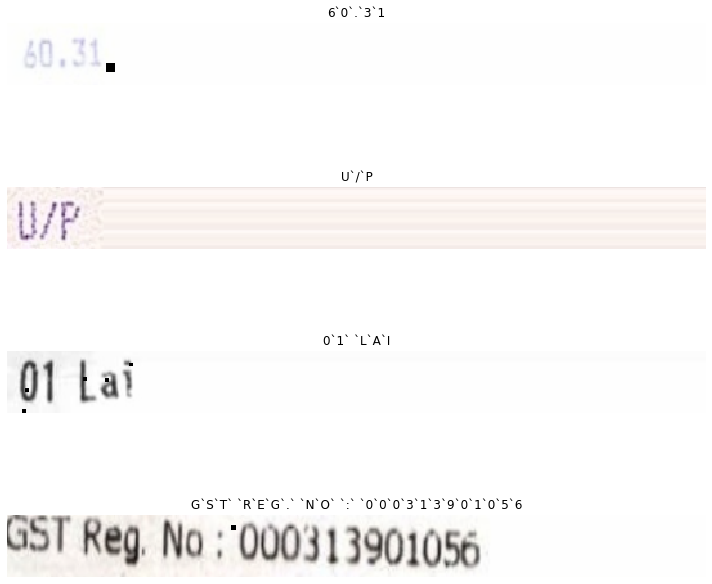

In [34]:
data.show_batch(4, figsize=(10,10))

In [35]:
dl = iter(data.valid_dl)
i, o = next(dl)
i.shape

torch.Size([16, 3, 48, 794])

In [36]:
data.c

70

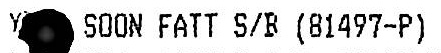

In [37]:
data.x[0]

In [38]:
data.y[0]

MultiCategory Y` `S`O`O`N` `F`A`T`T` `S`/`B` `(`8`1`4`9`7`-`P`)

In [39]:
data.y[0].data

tensor([59,  2, 53, 49, 49, 48,  2, 40, 35, 54, 54,  2, 53, 17, 36,  2, 10, 26,
        19, 22, 27, 25, 15, 50, 11])

### Learner

In [40]:
pad_idx = data.classes.index(crnn_config.label_delim)
ctc_loss = nn.CTCLoss(blank=pad_idx, reduction='mean', zero_infinity=True)

In [57]:
#export
def loss_func(y_pred, y_true, y_pred_len, y_true_len):
    # y_pred: [b,s_e,c], y_true: [[s_d], [s_d], ...], lengths: [b]
    b, s_e, c = y_pred.shape
    y_true = torch.cat(y_true, axis=0) # [b*s_d]
    y_pred = y_pred.log_softmax(axis=2).permute(1,0,2) # [ s_e, b, c ]
#     torch.backends.cudnn.enabled = False
    loss = ctc_loss(y_pred, y_true, y_pred_len, y_true_len)
#     torch.backends.cudnn.enabled = True
    return loss

In [58]:
#export
def print_metric(y_pred, y_true):
#     o = y_pred.argmax(-1)[0].cpu().numpy()
#     print('PRED:', MultiCategory(one_hot_text(o, data.c), [data.classes[p] for p in o], o))
#     o = y_true.argmax(-1)[0].cpu().numpy()
#     print('TRUE:', MultiCategory(one_hot_text(o, data.c), [data.classes[p] for p in o], o))
    return tensor(0)

In [59]:
#export
def decode_ctc(texts, classes):
    """ convert text-index into text-label. (make sure len(t) doesnt throw length of 0-dim error) """
    out = []
    index = 0
    for t in texts:
        char_list = []
        for i in range(len(t)):
            if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):  # removing repeated characters and blank.
                char_list.append(t[i])
#         text = ''.join(char_list)

        out.append(tensor(char_list))
    return out

In [60]:
decode = partial(decode_ctc, classes=data.classes)

In [61]:
#export
def wer(s1,s2):
    ''' s1 - true text, s2 - pred text '''
    d = np.zeros([len(s1)+1,len(s2)+1])
    d[:,0] = np.arange(len(s1)+1)
    d[0,:] = np.arange(len(s2)+1)

    for j in range(1,len(s2)+1):
        for i in range(1,len(s1)+1):
            if s1[i-1] == s2[j-1]:
                d[i,j] = d[i-1,j-1]
            else:
                d[i,j] = min(d[i-1,j]+1, d[i,j-1]+1, d[i-1,j-1]+1)

    return d[-1,-1]/len(s1)

word_error = wer( 'black frog jumped away'.split(' '), 'black frog jumped awayyy'.split(' ') )
char_error = wer( 'black frog jumped away', 'black frog jumped awayyy' )
char_error, word_error

(0.09090909090909091, 0.25)

In [62]:
#export
def CER(y_pred, y_true, y_pred_len, y_true_len):
    # y_pred: [b,s_e,c], y_true: [[s_d], [s_d], ...], lengths: [b]
    y_pred = y_pred.argmax(-1)
    y_pred = decode(y_pred)
    m = 0
    for yp, p_len, yt in zip(y_pred, y_pred_len, y_true):
        if yp.shape == torch.Size([]): continue
        yt_text = ''.join([learner.data.classes[i] for i in yt])
        yp_text = ''.join([learner.data.classes[i] for i in yp])
        m += wer(yt_text, yp_text)
    return tensor(m / len(y_pred))

In [63]:
#export
def WER(y_pred, y_true, y_pred_len, y_true_len):
    # y_pred: [b,s_e,c], y_true: [[s_d], [s_d], ...], lengths: [b]
    y_pred = y_pred.argmax(-1)
    y_pred = decode(y_pred)
    m = 0
    for yp, p_len, yt in zip(y_pred, y_pred_len, y_true):
        if yp.shape == torch.Size([]): continue
        yt_text = ''.join([learner.data.classes[i] for i in yt])
        yp_text = ''.join([learner.data.classes[i] for i in yp])
        m += wer(yt_text.split(' '), yp_text.split(' '))
    return tensor(m / len(y_pred))

In [53]:
# either load or create new learner
learner = load_inference('crnn_ocr')
learner.data = data

In [64]:
data = create_data(main_df, bs=16)
crnn = CRNN(nclass=data.c)

In [65]:
learner = Learner(data, crnn, loss_func=loss_func, metrics=[CER, WER])
learner.callbacks.append(ShowGraph(learner))

# learner.show_results(DatasetType.Train, rows=1)

In [50]:
# learner = Learner(data, CRNN(data.c), loss_func=loss_func, path='./models', metrics=[]).load('crnn')

In [51]:
def load_weights(learner, brno_leaner, load_everything=False): # brno - other (from where to laod weights)

    brno_params = dict(brno_learner.model.named_parameters())
    learn_params = dict(learner.model.named_parameters())

    for name, param in brno_params.items():
        if (not name.startswith('linear') and not name.startswith('rnn.1.embedding')) or load_everything:
            learn_params[name].data.copy_(param.data)

In [52]:
# load_weights(learner, load_learner(path='./models', file='crnn_exported_BRNO'), load_everything=False)

In [53]:
# load_weights(learner, load_learner(path='./models', file='crnn_exported'), load_everything=True)

In [54]:
# NOTE: to save/load there is 2 options:
# 1. save state (saved in './models/models/')

# learner.save('crnn')
# learner.load('crnn')

# 2. save exported model for inference (saved in './models/')

# learner.export('crnn_exported')
# load_learner(path='./models', file='crnn_exported')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-04
Min loss divided by 10: 1.45E-02


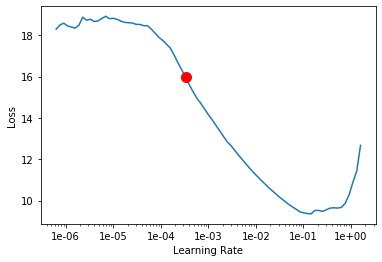

In [66]:
learner.lr_find()
learner.recorder.plot(skip_end=7,suggestion=True)

epoch,train_loss,valid_loss,CER,WER,time
0,0.114710,0.149627,0.039572,0.188475,06:12


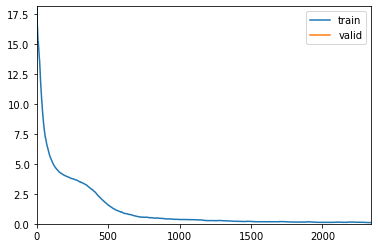

In [67]:
learner.fit_one_cycle(1, 1e-3)

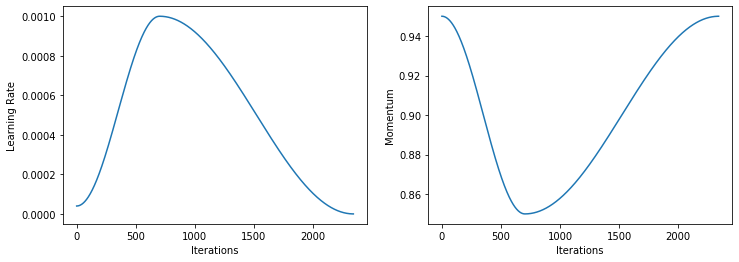

In [68]:
learner.recorder.plot_lr(show_moms=True)

epoch,train_loss,valid_loss,CER,WER,time
0,0.075631,0.116622,0.029826,0.149086,08:13


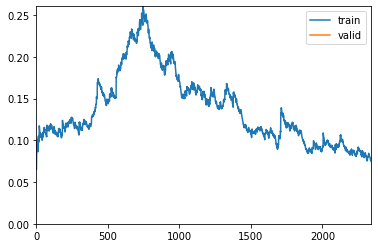

In [74]:
learner.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,CER,WER,time
0,0.085957,0.095637,0.022447,0.108524,09:18
1,0.078324,0.094451,0.030217,0.129741,09:18
2,0.090639,0.095922,0.050053,0.215120,09:16
3,0.077359,0.089994,0.020779,0.104272,09:16
4,0.051445,0.084078,0.019095,0.093347,09:17
5,0.050620,0.079043,0.017738,0.088421,09:17
6,0.037059,0.074868,0.015993,0.079284,09:18
7,0.030048,0.072892,0.015481,0.077535,09:17
8,0.022173,0.070481,0.014941,0.075418,09:18
9,0.022369,0.070722,0.014945,0.074082,09:18


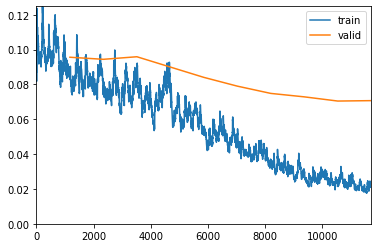

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [218]:
learner.fit_one_cycle(10, max_lr=1e-3)

In [76]:
save_inference(learner, 'crnn_ocr')

### Examples

In [70]:
learner = load_inference('crnn_ocr')
learner.data = data

In [71]:
dl = iter(learner.data.valid_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PRED: 1`````````6```````````G``````````````` ` ```B```````````L`````````O`O`````````C```````````K````````````` ` `````B`````````````````````````````````Z```````````E```````````N```````````I`````````T`````````H`H``````````````` ```C```````````O```````````R```````````P`````````O```````````R```````````A`A`````````T`````````E`E``````````` ` ` ```P`````````````A```````R`R`````````K````````````````````
TRUE: 1`6`G` `B`L`O`C`K` `B` `,`Z`E`N`I`T`H` `C`O`R`P`O`R`A`T`E` `P`A`R`K


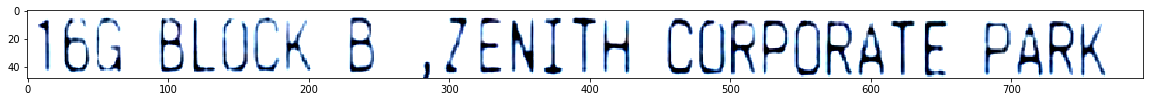

In [72]:
model = learner.model
model = model.eval()
a = next(dl)
i = 1
y_pred = model(a[0])
o = y_pred.argmax(-1)[i].cpu().numpy()
print('PRED:', MultiCategory(one_hot_text(o, data.c), [data.classes[p] for p in o], o))
print('TRUE:', MultiCategory(a[1], [data.classes[p] for p in a[1][0][i]], o))
plt.figure(figsize = (20,2))
_ = plt.imshow(a[0][i].permute(1,2,0).cpu().numpy(), interpolation='nearest')

In [73]:
''.join([data.classes[i] for i in decode([o])[0]])

'16G BLOCK BZENITH CORPORATE PARK'

### Eval

In [123]:
def calc_precision_recall(true_words, pred_words):
    num_preds, num_trues = len(pred_words), len(true_words)
    
    correct = 0
    for true_word in true_words:
        if true_word in pred_words:
            pred_words.remove(true_word)
            correct += 1
            continue

    precision = correct / num_preds
    recall = correct / num_trues
    # print(precision, recall, correct, num_preds)
    return precision, recall

In [124]:
def wer(s1,s2):
    ''' s1 - true text, s2 - pred text '''
    d = np.zeros([len(s1)+1,len(s2)+1])
    d[:,0] = np.arange(len(s1)+1)
    d[0,:] = np.arange(len(s2)+1)

    for j in range(1,len(s2)+1):
        for i in range(1,len(s1)+1):
            if s1[i-1] == s2[j-1]:
                d[i,j] = d[i-1,j-1]
            else:
                d[i,j] = min(d[i-1,j]+1, d[i,j-1]+1, d[i-1,j-1]+1)

    return d[-1,-1]/len(s1)

word_error = wer( 'black frog jumped away'.split(' '), 'black frog jumped awayyy'.split(' ') )
char_error = wer( 'black frog jumped away', 'black frog jumped awayyy' )
char_error, word_error

(0.09090909090909091, 0.25)

In [125]:
def idx2text(indexes):
    for i in indexes:
        try:
            data.classes[i]
        except:
            print('asd', i)
    return ''.join([data.classes[i] for i in indexes])

In [126]:
def evaluate_model(model, dl, t2list=lambda t: list(t.cpu().numpy()), total=None):
    total = len(dl) if total is None else total
    errors = 0
    ps, rs, ws, cs = [], [], [], []
    for images, (texts, im_lens, text_lens) in tqdm(iter(dl), total=total):
        y_pred = model(images).argmax(-1)
        pred_texts = decode(y_pred)
        for true_words, pred_words in zip(texts, pred_texts): # go through batch
            if list(pred_words.shape) == []:
#                 print('list(pred_words.shape) == []')
                errors += 1
                continue
            true_words, pred_words = t2list(true_words), t2list(pred_words)
            true_str, pred_str = idx2text(true_words), idx2text(pred_words)
            p,r = calc_precision_recall(true_words, pred_words)
            c = wer(true_str, pred_str)
            w = wer(true_str.split(' '), pred_str.split(' '))
            ps.append(p); rs.append(r); ws.append(w); cs.append(c)
    print('errors:', errors)
    return np.array(ps), np.array(rs), np.array(ws), np.array(cs)

# p, r, w, c = evaluate_model(learner.model.train(), data.valid_dl)

In [127]:
model = learner.model.eval()

In [128]:
p, r, w, c = evaluate_model(model, learner.data.train_dl)
c.mean(), w.mean(), p.mean(), r.mean()


errors: 7


(0.03110387135433626,
 0.11361194494518931,
 0.9809448185566668,
 0.9845791346994855)

In [129]:
p, r, w, c = evaluate_model(model, learner.data.valid_dl)
c.mean(), w.mean(), p.mean(), r.mean()


errors: 3


(0.02718612636301391,
 0.10763921705094984,
 0.9837173021269616,
 0.9834631378264629)